# Graph Transformer Neural Network

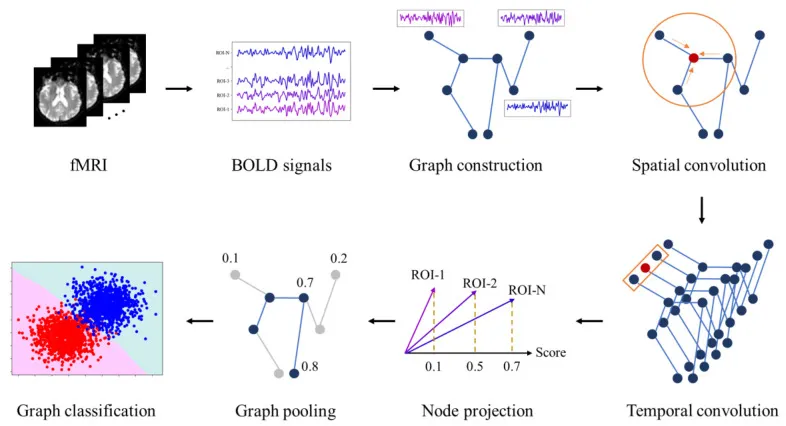
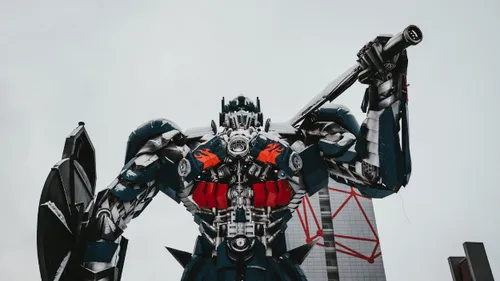
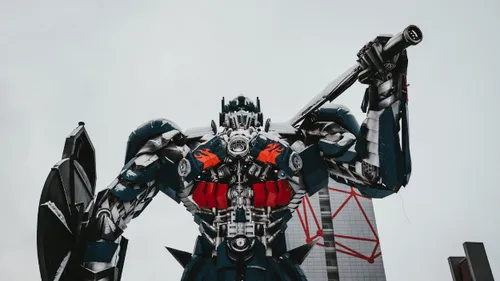
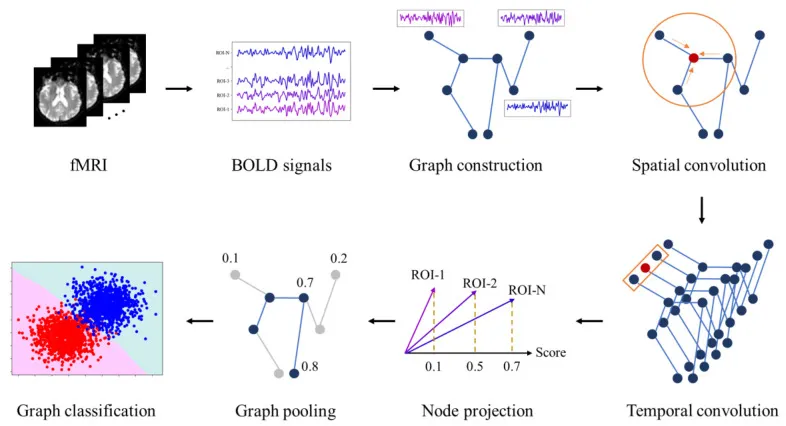

In [11]:
pip install --quiet torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install --quiet torch_optimizer

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Import necessary libraries

import torch
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
import torch.nn as nn
import torch_geometric
import torch.nn.functional as F
import torch_optimizer as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.nn import TransformerConv, global_mean_pool
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Load the Data

In [14]:
# Load the Data

csv_path = '/kaggle/input/pixar/pixar_pheno.csv'
pheno = pd.read_csv(csv_path)

feat_file = '/kaggle/input/pixar/pixar_features.npz' 
X_features = np.load(feat_file)['a']


# Map gender labels to 0 and 1 (Female = 0, Male = 1)
gender_map = {'F': 0, 'M': 1}
pheno['Gender_encoded'] = pheno['Gender'].map(gender_map)
y_labels = pheno['Gender_encoded']




print('Y shape:', y_labels.shape)
print('Phenotype shape:', pheno.shape)
print('Features shape:', X_features.shape)

Y shape: (155,)
Phenotype shape: (155, 7)
Features shape: (155, 2016)


## Prepare the graph data

In [15]:
# Create the symmetric matrix from vector (upper triangle of 64x64 matrix)
def vector_to_symmetric_matrix(vector, size=64):
    full_matrix = np.zeros((size, size))
    upper_triangle_indices = np.triu_indices(size, k=1)
    full_matrix[upper_triangle_indices] = vector
    full_matrix += full_matrix.T
    return full_matrix

# Convert the feature vectors into symmetric 64x64 matrices
reshaped_features = np.array([vector_to_symmetric_matrix(f) for f in X_features])


# Prepare the graph data
def prepare_data_for_gat(roi_matrices, labels):
    data_list = []
    for i in range(len(roi_matrices)):
        edge_index = torch.tensor(np.array(np.nonzero(roi_matrices[i] > 0)), dtype=torch.long)  # Non-zero edges
        edge_index = edge_index.contiguous()
        
        x = torch.tensor(roi_matrices[i], dtype=torch.float32)  # Node features
        y = torch.tensor(labels[i], dtype=torch.long)  # Labels
        
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list


# Prepare the data
data_list = prepare_data_for_gat(reshaped_features, y_labels)


# Split the data into training and test sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

## Early Stopping Setup

In [16]:
# Early Stopping Setup

class EarlyStopping:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_epoch = None
        self.stop_training = False

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
        return self.stop_training



## Transformer Model

In [17]:

class GraphTransformerGenderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.6):
        super(GraphTransformerGenderClassifier, self).__init__()

        # Transformer-based graph convolution layers
        self.transformer1 = TransformerConv(input_dim, hidden_dim, heads=8, dropout=dropout)
        self.transformer2 = TransformerConv(hidden_dim * 8, hidden_dim, heads=4, dropout=dropout)
        self.transformer3 = TransformerConv(hidden_dim * 4, output_dim, heads=1, dropout=dropout)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim * 8)  # BatchNorm after transformer1
        self.bn2 = nn.BatchNorm1d(hidden_dim * 4)  # BatchNorm after transformer2

        # Final classification layer for binary classification
        self.fc = nn.Linear(output_dim, 1)  # Output single logit for binary classification

    def forward(self, x, edge_index, batch):
        # Transformer-based layers
        x = self.transformer1(x, edge_index)
        x = F.gelu(x)  # GELU activation
        x = self.bn1(x)  # Batch normalization after first transformer

        x = self.transformer2(x, edge_index)
        x = F.gelu(x)  # GELU activation
        x = self.bn2(x)  # Batch normalization after second transformer

        x = self.transformer3(x, edge_index)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Final classification
        x = self.fc(x)  # Logits for BCEWithLogitsLoss
        return x

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    dropout = trial.suggest_uniform('dropout', 0.01, 0.8)
    hidden_dim = trial.suggest_int('hidden_dim', 8, 128)

    # Re-initialize the model with hyperparameters from the trial
    model = GraphTransformerGenderClassifier(input_dim=64, hidden_dim=hidden_dim, output_dim=8, dropout=dropout).to(device)
    
    # Use Ranger optimizer
    optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Use BCEWithLogitsLoss for binary classification
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
    
    # Early stopping setup
    early_stopping = EarlyStopping(patience=15, verbose=False)

    # Training loop
    for epoch in range(100):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output.view(-1), data.y.float())  # Use BCEWithLogitsLoss (output.view(-1) for single output)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Calculate accuracy (since BCEWithLogitsLoss gives continuous outputs, we apply a threshold for binary classification)
            predicted = (torch.sigmoid(output) > 0.5).long()  # Apply sigmoid and threshold at 0.5
            total += data.y.size(0)
            correct += (predicted.view(-1) == data.y).sum().item()

        scheduler.step()  # Step the scheduler at the end of each epoch

        accuracy = correct / total * 100
        val_loss = epoch_loss / len(train_loader)
        
        # Early stopping check
        if early_stopping(val_loss, epoch):
            break

    # Evaluation on the test set (for validation of this trial)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch)
            predicted = (torch.sigmoid(output) > 0.5).long()  # Apply sigmoid and threshold at 0.5
            total += data.y.size(0)
            correct += (predicted.view(-1) == data.y).sum().item()

    test_accuracy = correct / total * 100
    return test_accuracy  # Objective is to maximize the test accuracy

# Run the Optuna optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial and its parameters
best_trial = study.best_trial
print("Best Trial Params:", best_trial.params)
print("Best Trial Accuracy:", best_trial.value)


Using device: cuda
Best Trial Params: {'lr': 0.00021507500459297372, 'weight_decay': 0.0002083674487936455, 'dropout': 0.3404477423669716, 'hidden_dim': 90}
Best Trial Accuracy: 70.96774193548387


## Train the model

In [18]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_trial.params
print("Best Hyperparameters:", best_params)

# Initialize the model with the best hyperparameters
best_model = GraphTransformerGenderClassifier(
    input_dim=64,
    hidden_dim=best_params['hidden_dim'],
    output_dim=8,
    dropout=best_params['dropout']
).to(device)

# Initialize the optimizer and criterion with the best hyperparameters
optimizer = optim.Ranger(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

# Set up learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# Set up early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Train the model using the best hyperparameters
for epoch in range(100):
    best_model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = best_model(data.x, data.edge_index, data.batch)
        loss = criterion(output.view(-1), data.y.float())  # Apply BCEWithLogitsLoss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Compute accuracy (threshold sigmoid output at 0.5)
        predicted = (torch.sigmoid(output) > 0.5).long()
        total += data.y.size(0)
        correct += (predicted.view(-1) == data.y).sum().item()

    scheduler.step()  # Scheduler step

    accuracy = correct / total * 100
    val_loss = epoch_loss / len(train_loader)

    # Early stopping check
    if early_stopping(val_loss, epoch):
        break

# Evaluate on the test set
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = best_model(data.x, data.edge_index, data.batch)
        predicted = (torch.sigmoid(output) > 0.5).long()
        total += data.y.size(0)
        correct += (predicted.view(-1) == data.y).sum().item()

test_accuracy = correct / total * 100
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.2f}%")


Best Hyperparameters: {'lr': 0.00021507500459297372, 'weight_decay': 0.0002083674487936455, 'dropout': 0.3404477423669716, 'hidden_dim': 90}
Early stopping triggered at epoch 47
Test Accuracy with Best Hyperparameters: 61.29%


## Evaluate the model

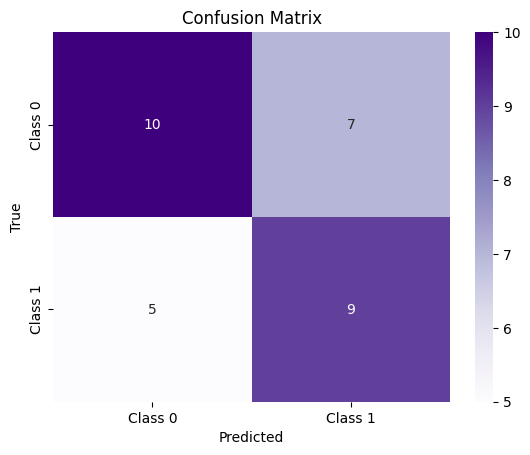

              precision    recall  f1-score   support

     Class 0       0.67      0.59      0.62        17
     Class 1       0.56      0.64      0.60        14

    accuracy                           0.61        31
   macro avg       0.61      0.62      0.61        31
weighted avg       0.62      0.61      0.61        31



In [19]:
from sklearn.metrics import confusion_matrix
# Get predictions and true labels
true_labels = []
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = best_model(data.x, data.edge_index, data.batch)
        predicted = (torch.sigmoid(output) > 0.5).long()
        true_labels.extend(data.y.cpu().numpy())
        predictions.extend(predicted.view(-1).cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

# Print classification report (precision, recall, F1-score)
print(classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1']))


## Feature Importance

In [34]:
# Load the Difumo Atlas (probabilistic brain regions)
difumo = datasets.fetch_atlas_difumo(dimension=64, resolution_mm=2, legacy_format=False)
atlas_filename = difumo.maps
labels = difumo.labels["difumo_names"]

In [42]:
# Running the feature importance analysis
perturbation_effects = create_perturbation_bank(best_model, test_loader)

# Creating a DataFrame for the feature importances
feature_names = ["ROI Feature " + str(i + 1) for i in range(64)]
perturbation_df = pd.DataFrame(perturbation_effects, columns=['Feature Index', 'Importance'])

# Map each feature index to both a feature name and its corresponding brain region label
perturbation_df['Feature Name'] = perturbation_df['Feature Index'].apply(lambda x: feature_names[x])
perturbation_df['Brain Region'] = perturbation_df['Feature Index'].apply(lambda x: labels[x])

# Sort by importance and reset index
perturbation_df = perturbation_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

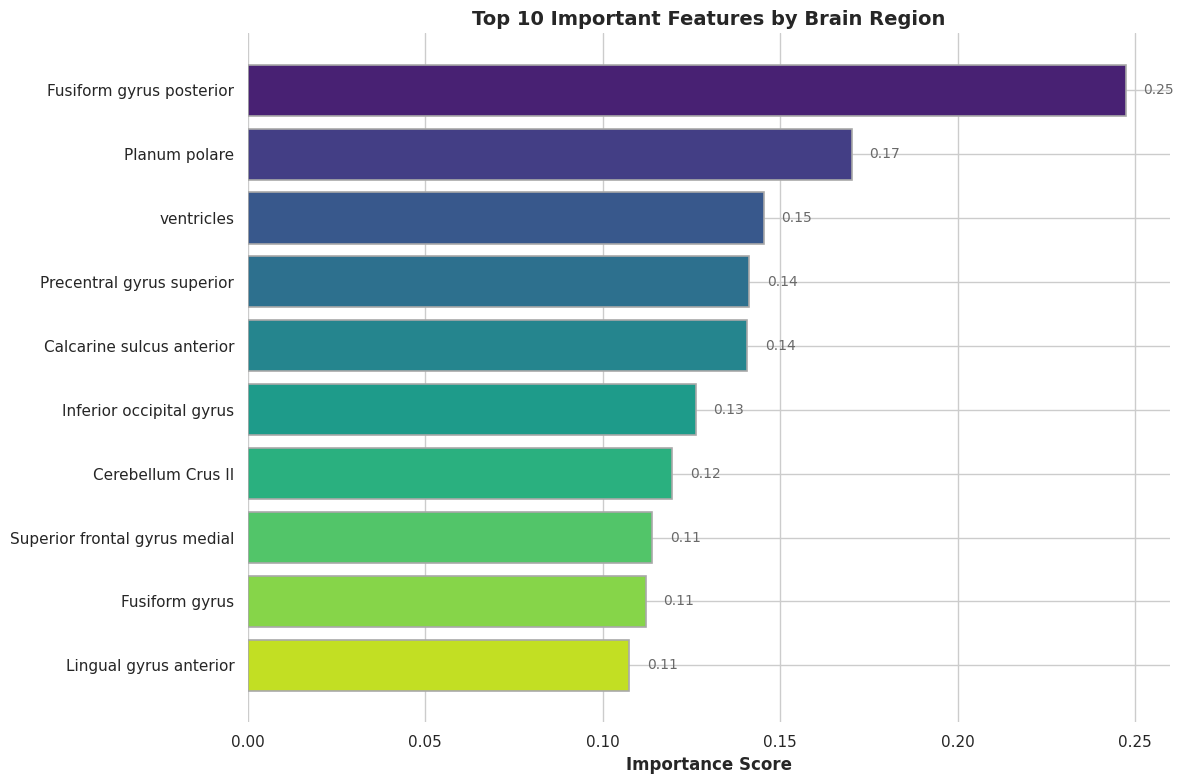

In [51]:
# Set a color palette and style for aesthetics
sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", top_n)

# Select the top 10 most important features
top_n = 10
top_features_df = perturbation_df.head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_features_df['Brain Region'], 
    top_features_df['Importance'], 
    color=cmap, 
    edgecolor='darkgrey', 
    linewidth=1.2
)

# Adding data labels on each bar
for bar, importance in zip(bars, top_features_df['Importance']):
    plt.text(
        bar.get_width() + 0.005,  # Position label just to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f'{importance:.2f}',  # Format to 2 decimal places
        va='center',
        fontsize=10,
        color='dimgrey'
    )

# Enhance plot aesthetics
plt.xlabel('Importance Score', fontsize=12, weight='bold')
plt.title(f'Top {top_n} Important Features by Brain Region', fontsize=14, weight='bold')
plt.gca().invert_yaxis()  # Invert y-axis for ranking

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [52]:
# Display the DataFrame with Feature Index, Importance, Feature Name, and Brain Region
perturbation_df  

,Feature Index,Importance,Feature Name,Brain Region
0,15,0.247407,ROI Feature 16,Fusiform gyrus posterior
1,18,0.170181,ROI Feature 19,Planum polare
2,14,0.145439,ROI Feature 15,ventricles
3,39,0.141289,ROI Feature 40,Precentral gyrus superior
4,30,0.140827,ROI Feature 31,Calcarine sulcus anterior
...,...,...,...,...
59,10,0.017094,ROI Feature 11,Transverse sinus
60,20,0.016078,ROI Feature 21,Cerebellum I-V
61,22,0.013324,ROI Feature 23,Anterior Cingulate Cortex
62,32,0.013177,ROI Feature 33,Superior parietal lobule anterior


In [27]:
# Wrap the model to ensure 2D output for SHAP or similar interpretability methods
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, roi_data, age):
        output = self.model(roi_data, age)
        return output.unsqueeze(1)  # Ensures output shape is (batch_size, 1)

# Create a wrapped version of the final model for SHAP or similar
wrapped_model = ModelWrapper(final_model)
wrapped_model.eval()

ModelWrapper(
  (model): GraphTransformerGenderClassifier(
    (transformer1): TransformerConv(64, 90, heads=8)
    (transformer2): TransformerConv(720, 90, heads=4)
    (transformer3): TransformerConv(360, 8, heads=1)
    (bn1): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [46]:
from torch.autograd import Variable

def integrated_gradients(model, data, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(data.x)  # Set baseline to zero if none is provided

    # Compute the integrated gradients
    gradients = torch.zeros_like(data.x)
    for step in range(steps):
        alpha = (step + 1) / steps
        input_alphas = baseline + alpha * (data.x - baseline)
        input_alphas = Variable(input_alphas, requires_grad=True)

        # Forward pass
        output = model(input_alphas, data.edge_index, data.batch)

        # Compute gradients
        output.sum().backward()
        gradients += input_alphas.grad

    # Average the gradients
    integrated_grads = gradients / steps
    return integrated_grads

# Calculate Integrated Gradients for a given data point
ig = integrated_gradients(best_model, data)


In [47]:
ig

tensor([[ 0.0079, -0.0296, -0.0153,  ...,  0.0106, -0.0120,  0.0084],
        [ 0.0065, -0.0289, -0.0187,  ...,  0.0117, -0.0127,  0.0112],
        [ 0.0034, -0.0329, -0.0187,  ...,  0.0100, -0.0093,  0.0057],
        ...,
        [ 0.0087, -0.0259, -0.0173,  ...,  0.0129, -0.0087,  0.0075],
        [ 0.0056, -0.0238, -0.0184,  ...,  0.0139, -0.0069,  0.0076],
        [ 0.0063, -0.0252, -0.0185,  ...,  0.0149, -0.0080,  0.0083]],
       device='cuda:0')